In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np

from catboost import CatBoostRegressor, Pool, cv

from hyperopt import fmin, hp, tpe, STATUS_OK, STATUS_FAIL, Trials
import pickle
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
tax = gpd.read_feather('../data/tax.geofeather')

In [3]:
tax['x'] = tax.geometry.centroid.x
tax['y'] = tax.geometry.centroid.y

In [83]:
tax.zillow_neighborhood_name = tax.zillow_neighborhood_name.fillna('NaN')

In [84]:
X = tax.drop(['property_location', 'block', 'lot', 'parcel_number', 
              'assessor_neighborhood', 'assessor_neighborhood_district', 
              'analysis_neighborhood', 
              'supervisor_district_2012', 'supervisor_district'], 
             axis=1)

In [85]:
X['assessed_sales_value'] = X['imputed_land_value'] + X['assessed_fixtures_value'] + X['assessed_improvement_value']


In [86]:
X.current_sales_date

0                NaT
1                NaT
2                NaT
3                NaT
4                NaT
             ...    
3086505   2003-04-30
3086506   2004-07-13
3086507          NaT
3086508   2015-03-05
3086509   2016-09-29
Name: current_sales_date, Length: 3086855, dtype: datetime64[ns]

In [7]:
fmv = X[(X.year_property_built >= (X.closed_roll_year - 1)) | (X.current_sales_date.dt.year >= (tax.closed_roll_year - 1))].copy()
fmv = fmv[fmv['assessed_sales_value'] > 0]
fmv = fmv.sort_values(['assessed_sales_value'], ascending=False).drop_duplicates(['year_property_built', 'current_sales_date', 'geometry'])

In [8]:
group = fmv['geometry'].astype(str)

In [9]:
fmv = fmv.drop(columns=['current_sales_date', 'geometry'])

In [10]:
X['assessed_sales_value'].mean()

1840948.5621128646

In [11]:
fmv['assessed_sales_value'].mean()

10114133.487307908

In [12]:
fmv['assessed_sales_value'].min()

1.0

In [13]:
fmv = fmv.drop(columns=['assessed_land_value', 'assessed_fixtures_value', 'assessed_improvement_value', 'assessed_personal_property_value'])
fmv.shape

(99496, 30)

In [67]:
fmv.zillow_neighborhood_name = fmv.zillow_neighborhood_name.fillna('NaN')

In [68]:
X_fmv = fmv.drop(columns='assessed_sales_value')
y_fmv = np.log(fmv['assessed_sales_value'])

In [69]:
cat_indices = np.where((X_fmv.dtypes == 'object') | (X_fmv.dtypes == 'string'))[0]

In [70]:
cat_indices

array([ 0,  1,  6,  9, 11, 14, 19, 22, 25])

In [49]:
(y_test_r == 'NaN').sum()

0

In [50]:
(y_train_r == "NaN").sum()

0

In [72]:
X_train_r.isna().sum()

property_class_code_definition       0
lot_code                             0
property_area                        0
volume_number                        0
percent_of_ownership               611
misc_exemption_value                 0
zoning_code                          0
year_property_built               3969
number_of_units                      0
use_definition                       0
closed_roll_year                     0
status_code                          0
number_of_bedrooms                   0
number_of_stories                    1
exemption_code_definition            0
lot_area                             0
number_of_rooms                      1
lot_depth                            0
number_of_bathrooms                  0
construction_type                    0
lot_frontage                         0
homeowner_exemption_value            0
tax_rate_area_code                   0
basement_area                        0
years_since_last_sale              528
zillow_neighborhood_name 

In [79]:
train_pool = Pool(data=X_fmv, label=y_fmv, cat_features=cat_indices)


In [ ]:

def hyperopt_objective(params):
    print(params)
    cv_data = cv(
        params=params,
        pool=train_pool,
        fold_count=5,
        shuffle=True,
        partition_random_seed=0,
        stratified=False,
        logging_level='Silent',
        early_stopping_rounds=10
    )
    loss = cv_data['test-RMSE-mean'].min()
    return loss


# We initiate a Trial object to keep track of search results and we set a hyperparameter space
trials = Trials()
space = {
    "iterations": 1000,
    'loss_function': 'RMSE',
    'learning_rate': hp.uniform('learning_rate', 0.25, 0.5),
    'depth': hp.randint('depth', 2, 10),
    'l2_leaf_reg': hp.loguniform('l2_leaf_reg', -5, 5),
    'border_count': hp.randint('border_count', 10, 255),
    'subsample': hp.uniform('subsample', 0.25, .75),
    'boosting_type': hp.choice('boosting_type', ['Ordered', 'Plain']),
}

# We finally use fmin to perform the search
'''
best = fmin(hyperopt_objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10,
            rstate=np.random.default_rng(42),
            trials=trials)
'''
print()

In [ ]:
best

In [16]:
best = {'boosting_type': 1,
 'border_count': 182,
 'depth': 3,
 'l2_leaf_reg': 2.5206936794284682,
 'learning_rate': 0.30305427924833384,
 'subsample': 0.4518888351309896}

In [17]:
best['boosting_type'] = 'Ordered' if best.get('boosting_type') == 0 else 'Plain'

In [74]:
kf = GroupKFold(n_splits=5)
r2_scores = []
i = 0
for train_index, test_index in kf.split(X_fmv, groups=group):
    print(i)
    X_train_r, X_test_r = X_fmv.iloc[train_index], X_fmv.iloc[test_index]
    y_train_r, y_test_r = y_fmv.iloc[train_index], y_fmv.iloc[test_index]

    train_dataset_r = Pool(data=X_train_r, label=y_train_r,  cat_features=cat_indices)
    test_dataset_r = Pool(data=X_test_r, label=y_test_r,  cat_features=cat_indices)

    model_r = CatBoostRegressor(iterations=1000, loss_function='RMSE', random_seed=0, verbose=1, **best)
    model_r.fit(train_dataset_r, verbose=0)

    predictions_r = model_r.predict(test_dataset_r)
    r2 = r2_score(y_test_r, predictions_r)
    r2_scores.append(r2)
    i += 1
r2_scores

0
1
2
3
4


[0.949717389237138,
 0.9535876058273772,
 0.9715823130506168,
 0.9717120997136306,
 0.9409928092082617]

In [ ]:
r2_scores

In [75]:
sum(r2_scores) / 5

0.9575184434074048

In [ ]:
pickle.dump(trials, open("my_trials_fmv.pkl", "wb"))

with open("my_trials_fmv.pkl", "rb") as f:
    object = pickle.load(f)

df_trials = pd.DataFrame(object)
df_trials.to_csv(r'catboost_results_fmv.csv')

In [77]:
catboostFinal = CatBoostRegressor(**best, loss_function='RMSE', random_seed=0, iterations=1000)

In [80]:
catboostFinal.fit(train_pool)

0:	learn: 0.8656157	total: 15ms	remaining: 15s
1:	learn: 0.6952279	total: 30.1ms	remaining: 15s
2:	learn: 0.5642553	total: 44.4ms	remaining: 14.8s
3:	learn: 0.4794197	total: 58ms	remaining: 14.4s
4:	learn: 0.4129092	total: 71.6ms	remaining: 14.2s
5:	learn: 0.3689168	total: 85.3ms	remaining: 14.1s
6:	learn: 0.3378830	total: 98.5ms	remaining: 14s
7:	learn: 0.3170357	total: 111ms	remaining: 13.8s
8:	learn: 0.3035362	total: 121ms	remaining: 13.4s
9:	learn: 0.2936455	total: 135ms	remaining: 13.3s
10:	learn: 0.2848584	total: 146ms	remaining: 13.2s
11:	learn: 0.2792621	total: 158ms	remaining: 13s
12:	learn: 0.2748121	total: 171ms	remaining: 13s
13:	learn: 0.2673171	total: 183ms	remaining: 12.9s
14:	learn: 0.2644174	total: 196ms	remaining: 12.8s
15:	learn: 0.2621084	total: 208ms	remaining: 12.8s
16:	learn: 0.2598512	total: 221ms	remaining: 12.8s
17:	learn: 0.2581888	total: 235ms	remaining: 12.8s
18:	learn: 0.2564819	total: 246ms	remaining: 12.7s
19:	learn: 0.2552049	total: 257ms	remaining: 12.

164:	learn: 0.1857606	total: 2.07s	remaining: 10.5s
165:	learn: 0.1856133	total: 2.09s	remaining: 10.5s
166:	learn: 0.1855135	total: 2.1s	remaining: 10.5s
167:	learn: 0.1854612	total: 2.11s	remaining: 10.4s
168:	learn: 0.1850280	total: 2.12s	remaining: 10.4s
169:	learn: 0.1849839	total: 2.14s	remaining: 10.4s
170:	learn: 0.1848924	total: 2.15s	remaining: 10.4s
171:	learn: 0.1847337	total: 2.16s	remaining: 10.4s
172:	learn: 0.1845162	total: 2.17s	remaining: 10.4s
173:	learn: 0.1844409	total: 2.18s	remaining: 10.4s
174:	learn: 0.1844235	total: 2.19s	remaining: 10.4s
175:	learn: 0.1843266	total: 2.21s	remaining: 10.3s
176:	learn: 0.1842869	total: 2.22s	remaining: 10.3s
177:	learn: 0.1842506	total: 2.23s	remaining: 10.3s
178:	learn: 0.1842339	total: 2.24s	remaining: 10.3s
179:	learn: 0.1840965	total: 2.26s	remaining: 10.3s
180:	learn: 0.1836491	total: 2.27s	remaining: 10.3s
181:	learn: 0.1834942	total: 2.28s	remaining: 10.3s
182:	learn: 0.1833497	total: 2.3s	remaining: 10.3s
183:	learn: 0.

326:	learn: 0.1693629	total: 4.12s	remaining: 8.47s
327:	learn: 0.1693108	total: 4.13s	remaining: 8.46s
328:	learn: 0.1693103	total: 4.14s	remaining: 8.44s
329:	learn: 0.1692582	total: 4.15s	remaining: 8.43s
330:	learn: 0.1691840	total: 4.16s	remaining: 8.41s
331:	learn: 0.1691389	total: 4.17s	remaining: 8.4s
332:	learn: 0.1690261	total: 4.19s	remaining: 8.39s
333:	learn: 0.1690059	total: 4.2s	remaining: 8.38s
334:	learn: 0.1688956	total: 4.21s	remaining: 8.37s
335:	learn: 0.1687477	total: 4.23s	remaining: 8.35s
336:	learn: 0.1687333	total: 4.24s	remaining: 8.34s
337:	learn: 0.1686560	total: 4.25s	remaining: 8.33s
338:	learn: 0.1685682	total: 4.26s	remaining: 8.31s
339:	learn: 0.1685662	total: 4.27s	remaining: 8.3s
340:	learn: 0.1685363	total: 4.29s	remaining: 8.29s
341:	learn: 0.1683988	total: 4.3s	remaining: 8.27s
342:	learn: 0.1683967	total: 4.31s	remaining: 8.26s
343:	learn: 0.1683438	total: 4.33s	remaining: 8.25s
344:	learn: 0.1683378	total: 4.34s	remaining: 8.24s
345:	learn: 0.16

494:	learn: 0.1603526	total: 6.19s	remaining: 6.31s
495:	learn: 0.1603052	total: 6.2s	remaining: 6.3s
496:	learn: 0.1602783	total: 6.21s	remaining: 6.28s
497:	learn: 0.1601828	total: 6.22s	remaining: 6.27s
498:	learn: 0.1601746	total: 6.23s	remaining: 6.26s
499:	learn: 0.1601512	total: 6.25s	remaining: 6.25s
500:	learn: 0.1601005	total: 6.26s	remaining: 6.23s
501:	learn: 0.1600852	total: 6.27s	remaining: 6.22s
502:	learn: 0.1600534	total: 6.28s	remaining: 6.21s
503:	learn: 0.1600094	total: 6.29s	remaining: 6.19s
504:	learn: 0.1599781	total: 6.3s	remaining: 6.18s
505:	learn: 0.1598956	total: 6.32s	remaining: 6.17s
506:	learn: 0.1598851	total: 6.33s	remaining: 6.16s
507:	learn: 0.1598548	total: 6.35s	remaining: 6.15s
508:	learn: 0.1598400	total: 6.36s	remaining: 6.13s
509:	learn: 0.1598089	total: 6.37s	remaining: 6.12s
510:	learn: 0.1598035	total: 6.38s	remaining: 6.11s
511:	learn: 0.1597672	total: 6.4s	remaining: 6.1s
512:	learn: 0.1597642	total: 6.41s	remaining: 6.08s
513:	learn: 0.159

664:	learn: 0.1530714	total: 8.27s	remaining: 4.17s
665:	learn: 0.1530319	total: 8.28s	remaining: 4.15s
666:	learn: 0.1530227	total: 8.29s	remaining: 4.14s
667:	learn: 0.1529918	total: 8.31s	remaining: 4.13s
668:	learn: 0.1529530	total: 8.32s	remaining: 4.12s
669:	learn: 0.1529214	total: 8.33s	remaining: 4.11s
670:	learn: 0.1528668	total: 8.35s	remaining: 4.09s
671:	learn: 0.1528643	total: 8.36s	remaining: 4.08s
672:	learn: 0.1528215	total: 8.37s	remaining: 4.07s
673:	learn: 0.1528104	total: 8.38s	remaining: 4.05s
674:	learn: 0.1527560	total: 8.39s	remaining: 4.04s
675:	learn: 0.1526693	total: 8.4s	remaining: 4.03s
676:	learn: 0.1526124	total: 8.42s	remaining: 4.01s
677:	learn: 0.1525610	total: 8.43s	remaining: 4s
678:	learn: 0.1525505	total: 8.44s	remaining: 3.99s
679:	learn: 0.1525485	total: 8.45s	remaining: 3.98s
680:	learn: 0.1525265	total: 8.48s	remaining: 3.97s
681:	learn: 0.1525090	total: 8.49s	remaining: 3.96s
682:	learn: 0.1524994	total: 8.5s	remaining: 3.95s
683:	learn: 0.152

830:	learn: 0.1484599	total: 10.3s	remaining: 2.1s
831:	learn: 0.1484332	total: 10.3s	remaining: 2.09s
832:	learn: 0.1484080	total: 10.3s	remaining: 2.08s
833:	learn: 0.1484076	total: 10.4s	remaining: 2.06s
834:	learn: 0.1483725	total: 10.4s	remaining: 2.05s
835:	learn: 0.1482898	total: 10.4s	remaining: 2.04s
836:	learn: 0.1482871	total: 10.4s	remaining: 2.02s
837:	learn: 0.1482103	total: 10.4s	remaining: 2.01s
838:	learn: 0.1481977	total: 10.4s	remaining: 2s
839:	learn: 0.1481705	total: 10.4s	remaining: 1.99s
840:	learn: 0.1481253	total: 10.5s	remaining: 1.98s
841:	learn: 0.1481122	total: 10.5s	remaining: 1.96s
842:	learn: 0.1480773	total: 10.5s	remaining: 1.95s
843:	learn: 0.1480573	total: 10.5s	remaining: 1.94s
844:	learn: 0.1480362	total: 10.5s	remaining: 1.93s
845:	learn: 0.1480295	total: 10.5s	remaining: 1.91s
846:	learn: 0.1480123	total: 10.5s	remaining: 1.9s
847:	learn: 0.1479939	total: 10.5s	remaining: 1.89s
848:	learn: 0.1479695	total: 10.5s	remaining: 1.88s
849:	learn: 0.147

999:	learn: 0.1442258	total: 12.4s	remaining: 0us


In [87]:
X = tax.drop(columns = 
             ['property_location', 'block', 'lot', 'parcel_number', 
              'assessor_neighborhood', 'assessor_neighborhood_district', 
              'analysis_neighborhood',
              'supervisor_district_2012', 'supervisor_district', 'geometry', 
              'current_sales_date', 
              'assessed_land_value',
              'assessed_fixtures_value',
              'assessed_improvement_value', 
              'assessed_personal_property_value'])


In [88]:
predictions = catboostFinal.predict(X)

In [89]:
np.exp(predictions.min())

0.25802069392720506

In [90]:
tax['imputed_fair_market_acquisition'] = np.exp(predictions)

In [91]:
tax.loc[fmv.index, 'imputed_fair_market_acquisition'].sample(10, random_state=0)

1618498    6.969000e+05
134052     8.219433e+05
2537581    5.819203e+05
689135     2.637031e+05
393325     9.196738e+05
38419      7.591069e+05
179653     2.074402e+06
309313     1.253260e+06
774924     7.064721e+04
2128330    5.362126e+04
Name: imputed_fair_market_acquisition, dtype: float64

In [92]:
tax.loc[fmv.index, 'imputed_fair_market_acquisition'] = fmv['assessed_sales_value']

In [93]:
tax.loc[fmv.index, 'imputed_fair_market_acquisition'].sample(10, random_state=0)

1618498     739500.0
134052      810000.0
2537581     636526.0
689135      271500.0
393325      925650.0
38419       742050.0
179653     2040000.0
309313     1224000.0
774924      109721.0
2128330      45824.0
Name: imputed_fair_market_acquisition, dtype: float64

In [94]:
tax[tax['imputed_fair_market_acquisition'] == tax['imputed_fair_market_acquisition'].max()]

,property_class_code_definition,lot_code,property_area,volume_number,percent_of_ownership,misc_exemption_value,zoning_code,year_property_built,analysis_neighborhood,number_of_units,...,assessed_land_value,basement_area,assessed_improvement_value,geometry,years_since_last_sale,zillow_neighborhood_name,x,y,imputed_land_value,imputed_fair_market_acquisition
1113316,Condominium,NA,784.0,44.0,1.0,0.0,NA,2016.0,Mission Bay,0.0,...,0.0,0.0,0.0,POINT (-210583.622 -24527.893),7.025325,South Of Market,-210583.622305,-24527.893049,1.241680e+11,1.241680e+11
1117074,Condominium,NA,681.0,44.0,1.0,0.0,NA,2016.0,Mission Bay,0.0,...,0.0,0.0,0.0,POINT (-210583.622 -24527.893),7.041752,South Of Market,-210583.622305,-24527.893049,1.241680e+11,1.241680e+11


In [95]:
diff = (tax['imputed_fair_market_acquisition'] - (tax['assessed_land_value'] + tax['assessed_improvement_value'] + tax['assessed_fixtures_value']))

In [96]:
diff.describe()

count    3.086855e+06
mean     8.152048e+05
std      1.569121e+08
min     -1.340346e+09
25%     -1.126596e+03
50%      3.319643e+04
75%      1.602563e+05
max      1.241680e+11
dtype: float64

/opt/anaconda3/envs/salim/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


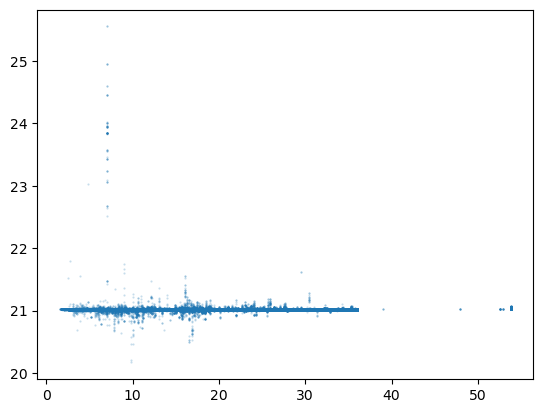

In [97]:
plt.scatter(tax['years_since_last_sale'], np.log((abs(diff.min()) + diff)), alpha=.25, s=.25)

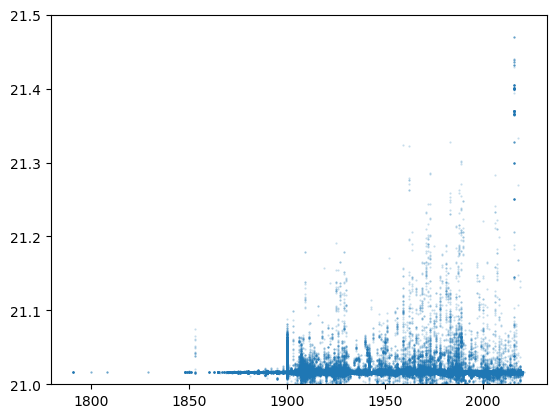

In [98]:
plt.scatter(tax['year_property_built'], np.log1p((abs(diff.min()) + diff)), alpha=.25, s=.25)
plt.ylim((21, 21.5))
plt.show()

In [99]:
tax.sort_values('imputed_fair_market_acquisition', ascending=True)

,property_class_code_definition,lot_code,property_area,volume_number,percent_of_ownership,misc_exemption_value,zoning_code,year_property_built,analysis_neighborhood,number_of_units,...,assessed_land_value,basement_area,assessed_improvement_value,geometry,years_since_last_sale,zillow_neighborhood_name,x,y,imputed_land_value,imputed_fair_market_acquisition
2730222,Port Commission Property,NA,0.0,44.0,NaN,0.0,M2,NaN,Mission Bay,0.0,...,0.0,0.0,0.0,POINT (-209982.289 -23632.951),3.674196,South Of Market,-209982.289372,-23632.950853,1.147321e+01,2.580207e-01
2728799,Port Commission Property,NA,0.0,44.0,NaN,0.0,M2,NaN,Mission Bay,0.0,...,0.0,0.0,0.0,POINT (-209832.006 -23624.912),3.674196,South Of Market,-209832.006464,-23624.911966,1.147321e+01,2.580207e-01
2725464,Port Commission Property,NA,0.0,44.0,NaN,0.0,M2,NaN,Mission Bay,0.0,...,0.0,0.0,0.0,POINT (-209800.850 -24895.411),53.837098,South Of Market,-209800.850093,-24895.411349,2.206666e+01,3.617866e-01
2730637,Port Commission Property,NA,0.0,44.0,NaN,0.0,C2,1900.0,Financial District/South Beach,0.0,...,0.0,0.0,0.0,POINT (-210611.918 -21695.589),NaN,Financial District,-210611.918161,-21695.588870,1.058372e+02,3.829750e-01
2730463,Port Commission Property,NA,0.0,44.0,NaN,0.0,M2,NaN,Potrero Hill,0.0,...,0.0,0.0,0.0,POINT (-209907.110 -25214.328),53.837098,Potrero Hill,-209907.109758,-25214.328349,1.084740e+02,3.943993e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1112218,Condominium,NA,828.0,44.0,1.0,0.0,NA,2016.0,Mission Bay,0.0,...,0.0,0.0,0.0,POINT (-210583.622 -24527.893),7.028063,South Of Market,-210583.622305,-24527.893049,6.769422e+10,6.769422e+10
1111673,Condominium,NA,826.0,44.0,1.0,0.0,NA,2016.0,Mission Bay,0.0,...,0.0,0.0,0.0,POINT (-210583.622 -24527.893),7.039014,South Of Market,-210583.622305,-24527.893049,6.769422e+10,6.769422e+10
1115911,Condominium,NA,826.0,44.0,1.0,0.0,NA,2016.0,Mission Bay,0.0,...,0.0,0.0,0.0,POINT (-210583.622 -24527.893),7.069131,South Of Market,-210583.622305,-24527.893049,6.769422e+10,6.769422e+10
1113316,Condominium,NA,784.0,44.0,1.0,0.0,NA,2016.0,Mission Bay,0.0,...,0.0,0.0,0.0,POINT (-210583.622 -24527.893),7.025325,South Of Market,-210583.622305,-24527.893049,1.241680e+11,1.241680e+11


In [100]:
tax.to_feather('../data/fair_market_acquisition.geofeather')